# The Roofline Model and Performance Metrics

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import timeit
from IPython.display import YouTubeVideo

## von Neumann Architecture

In 1945, [ENIAC](https://en.wikipedia.org/wiki/ENIAC), the first electronic general purpose digital computer was put to work. John von Neumann, a mathematician working on the hydrogen bomb at Los Alamos National Laboratory in the US, became aware of the ENIAC computer and realized its potential to speedup the computations actual people were doing. He subsequently became deeply involved in the design of such computers and published an architecture still in use in modern computers which became known as the [von Neumann architecture](https://en.wikipedia.org/wiki/Von_Neumann_architecture).

![von Neumann architecture](img/von_neumann_architecture.png)

The von Neumann architecture is based on the stored-program computer concept, where the instructions to be executed as well as the data are stored in a <font color="orange">*memory unit*</font> which typically consists of RAM. The memory unit is connected to the <font color="blue">*central processing unit (CPU)*</font> via a connection called a <font color="green">*bus*</font>. The instructions need to be transferred to the *control unit* in the CPU in order to be executed. The control unit of each CPU understands a certain set of instructions. Load and store instructions are responsible for transferring data from and to the memory. The *arithmetic / logic unit* is responsible for operations on data, such as performing addition or multiplication.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Think of some advantages / disadvantages of this computer architecture.<br>
<b>2.</b> Another popular computer architecture mostly used in microcontrollers and signal processing is the Harvard architecture. Look it up and figure out how it is different.<br>
</div>

In [2]:
# 1) TODO
# Advantages
# - Simple architecture, easier to program
# - Program and data are stored in the same memory (can be read the same way)
# Disadvantages
# - Data and program compete for resources on the same memory bus
# - CPU is typicall much faster than data bus, meaning it often has to wait (Von Neumann bottleneck)

# 2) TODO
# See for example https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Electronics/Implementing_a_One_Address_CPU_in_Logisim_(Kann)/01%3A_Introduction/1.03%3A_Von_Neumann_and_Harvard_Architectures
# Or for example https://www.youtube.com/watch?v=4nY7mNHLrLk

## Clock Rate

The CPU contains a [clock](https://en.wikipedia.org/wiki/Clock_rate) which is responsible for synchronizing the operations of its components (see figure above). Some components (e.g. memory) may have its own clock (see figure above). For example, in a simple CPU, an instruction is executed every clock cycle. In modern CPUs the situation is slightly more complex since engineers have found ways to design the chip in such a manner that it may be possible to execute multiple instructions in one clock cycle using techniques such as instruction pipelining or out-of-order execution. The metric measuring the number of *clock cycles per instruction (CPI)* is often reported when investigating the performance of a program.

The clock signal transitions from 0 to 1 and back to 0 and so on with a given frequency, the *clock frequency* or *clock rate*. The clock rate is measured in hertz (Hz). Common clock rates of modern CPUs are in the range of gigahertz (GHz).

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Find out the clock frequency of the Intel Haswell CPUs of Piz Daint by inspecting the <tt>/proc/cpuinfo</tt> file (see below).<br>
<b>4.</b> Modern CPUs have multiple cores, which each contain a control unit and an ALU. Find out the number of cores on the CPUs of Piz Daint. Check your answer on the <a href="https://www.cscs.ch/computers/piz-daint/">CSCS website</a> looking at data for the Piz Daint XC50 compute nodes.<br>
</div>

In [3]:
clock_frequency = 2.60e9 # TODO
number_of_cores = 12 # TODO

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
stepping	: 2
microcode	: 0x43
cpu MHz		: 2074.542
cache size	: 30720 KB
physical id	: 0
siblings	: 24
core id		: 0
cpu cores	: 12
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 15
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm cpuid_fault epb invpcid_single pti intel_ppin ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm xsaveopt cqm_llc cqm_occup_llc dtherm ida arat pln pts md_clear

## FLOP/s

In high-performance computing, a common measure of performance is the number of *floating-point operations (FLOP)*, i.e. multiplications, additions, ...) per second. This stems from the fact, that scientific programs such as weather and climate models often involve a large number of floating point operations.

![flops](img/flops.png)

The [fastest supercomputer](https://en.wikipedia.org/wiki/Fugaku_(supercomputer)) in the world currently achieves an incredible 1.102 Exaflop/s in double precision. (See also [this page](https://kb.iu.edu/d/apeq) for more information.) There is a list keeping track of the fastest supercomputers called the [top500](https://www.top500.org) which is updated bi-anually.

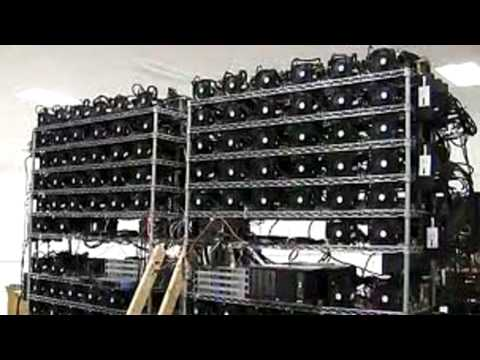

In [5]:
YouTubeVideo('ZaJp6ZYP6Xc')

## Theoretical Peak Performance

A processor's theoretical peak performance is a an upper bound for the floating-point performance one can expect from a CPU. It is computed as

$$\mathrm{peak_{FLOPS}} = 2 \times \mathrm{cores} \times f \times n$$

where *cores* is the number of cores on a CPU, $f$ is the clock frequency, and $n$ is the number of floating-point operations the processor can perform per clock cycle. The factor of 2 in front is because most modern processors have an [multiply-accumulate](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) instruction - also called fused multiply-add - which executes a multiplication and an addition in a single instruction.

$$\mathrm{fmad}(a,b,c) = a + (b \times c)$$

The Intel E5-2690 v3 Haswell processor on Piz Daint have a value of $n=8$, meaning that they can execute 8 double precision floating point operations in a single clock cycle. This is due to so called vector registers and vector instructions. More information about the theoretical peak performance of Intel processors can be found [here](http://www.dolbeau.name/dolbeau/publications/peak.pdf).

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>5.</b> Compute how many floating point operations each person on Earth would have to do per second in order to achieve 1.102 Exaflop/s. That didn't help, still impossible to imagine! Can you think of a cool way of explaining what 1.102 Exaflop/s means?<br>
<b>6.</b> Compute the theoretical peak performance of the Intel E5-2690 v3 Haswell processors you are currently working on. Can you think of some reasons why achieving peak performance is difficult for a real application?<br>
<b>7.</b> Take a look at the <tt>logistic_map</tt> method below. Compute the number of FLOP that <tt>logicist_map</tt> method will execute given values of <tt>number_of_iterations</tt>, <tt>number_of_r_values</tt>, and <tt>number_of_x_values</tt> (Hint: ignore the plotting for your calculation).<br>
<b>8.</b> Run the Python code to execute and time <tt>logistic_map</tt>. Compute the fraction of theoretical peak performance we have achieved.<br>
<b>9.</b> Change the code to no longer plot the result and measure performance once again.<br>
<b>10.</b> Did you expect the resulting value? Why?<br>
</div>

In [9]:
flops_per_capita = 1.102e18 / 7.753e9 # TODO
print("FLOP/s per person = {}".format(flops_per_capita))

FLOP/s per person = 142138527.021798


In [10]:
peak_performance_in_gflops = 2 * number_of_cores * clock_frequency * 8 * 1.e-9 # TODO
print("peak performance = {} GFLOP/s".format(peak_performance_in_gflops))
# One reason why this is difficult to achieve: We assume that we are using only FMA instructions,
# the application would have to have a perfect 1:1 mix of additions and multiplications in the right order

peak performance = 499.20000000000005 GFLOP/s


execution time = 0.4869900029152632 s
performance = 0.15400726822117144 GFLOP/s
% of peak =  0.03085%


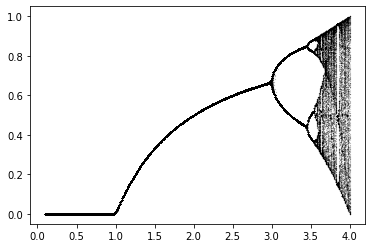

In [25]:
number_of_iterations = 100
number_of_r_values = 500
number_of_x_values = 500

def logistic_map(do_plot=False):
    for r in np.linspace(0.1, 4., number_of_r_values):
        x = np.linspace(0.01, 0.99, number_of_x_values)
        for iter in range(number_of_iterations):
            x = r * x * ( 1. - x )
        if do_plot:
            plt.plot(np.repeat(r, number_of_x_values), x, 'k.', markersize=0.1)

# total number of floating-point operations
number_of_flop = 3 * number_of_iterations * number_of_r_values * number_of_x_values # TODO

# time the execution
tic = timeit.default_timer()
logistic_map(do_plot=True)
toc = timeit.default_timer()
execution_time = toc - tic
print("execution time = {} s".format(execution_time))

# compute the flop/s
performance_in_gflops = number_of_flop / execution_time * 1.e-9 # TODO
print("performance = {} GFLOP/s".format(performance_in_gflops))

# compute fraction of peak
fraction_of_peak_performance = performance_in_gflops / peak_performance_in_gflops # TODO
print("% of peak = {:8.5f}%".format(fraction_of_peak_performance * 100.))

## Memory Bandwidth

In the von Neumann architecture the memory (RAM) is connected to the CPU via a [bus](https://en.wikipedia.org/wiki/Bus_(computing)), which is a technical term for a connection between two hardware units in a computer. In the picture below of an actual Cray supercomputer the memory (RAM) is on separate hardware components next to the CPU. The electrical wires connecting the memory to the CPU and the communication protocol are collectively referd to as the memory bus. 

![xc30 node](img/xc30_node.png)

[Memory bandwidth](https://en.wikipedia.org/wiki/Memory_bandwidth) is the rate at which data can be transferred between the CPU and memory. The unit used to specify memory bandwidth of modern processors is GB/s (gigabyte/s).

## Theoretical Peak Bandwidth

Theoretical peak memory bandwidth can be calculated from the clock frequency of the memory bus $f$ (memory clock frequency), the number of channels and the width of the memory bus (number of bits)

$$\mathrm{peak_{BW}} = f_\mathrm{DDR} \times \mathrm{channels} \times \mathrm{width}$$

The Piz Daint compute nodes use DDR4 memory with a frequency of $2133 MHz$ and has a memory bus with 4 channels each 64 bits wide. See [information by Intel](https://ark.intel.com/content/www/us/en/ark/products/81713/intel-xeon-processor-e5-2690-v3-30m-cache-2-60-ghz.html) for more details.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>11.</b> Use the <tt>sys.getsizeof()</tt> method to investigate the number of bytes different numpy data types occupy in memory (byte, float32, float64, int32, int64). The results are slightly larger than expected because Python stores additional information about objects that also occupy some space, but it is safe to round these numbers for large data arrays. Change the <tt>num_elements</tt> to 1 in order to check the fixed overhead of storing data in a numpy array. This is a fixed overhead, since as you increase the number of elements in the data array, the values approach the expected valued, i.e. 4 bytes for a <tt>float32</tt> and 8 bytes for a <tt>float64</tt>.<br>
<b>12.</b> Compute the theoretical peak memory bandwidth of the Intel E5-2690 v3 Haswell processors you are currently working on.<br>
<b>13.</b> Take a look at the <tt>vector_add</tt> method below. Compute the total number of bytes and GB that have to be loaded from or stored to memory for the <tt>vector_add</tt> method.<br>
<b>14.</b> Run the vector addition and compute the achieved memory bandwidth in GB/s and the % of the theorical peak memory bandwidth. You will have to add timers around the <tt>vector_add(a, b, c)</tt> invocation (see above). Is the result what you expected?<br>
</div>

In [9]:
data_types = [np.byte, np.float32, np.float64, np.int32, np.int64]
num_elements = 1024 * 1024
for data_type in data_types:
    x = np.empty((num_elements), dtype=data_type)
    print('{} has a size of {:.4f} bytes'.format(data_type.__name__, sys.getsizeof(x) / num_elements))

int8 has a size of 1.0001 bytes
float32 has a size of 4.0001 bytes
float64 has a size of 8.0001 bytes
int32 has a size of 4.0001 bytes
int64 has a size of 8.0001 bytes


In [16]:
peak_bandwidth_in_gbs = 2133.e6 * 4 * 64/8 / 1024**3 # TODO
print("peak memory bandwidth = {} GB/s".format(peak_bandwidth_in_gbs))

peak memory bandwidth = 63.5683536529541 GB/s


In [26]:
def vector_add(a, b, c):
    c[:] = a[:] + b[:]

num_elements = 128 * 1024 * 1024
a = np.random.rand( num_elements )
b = np.random.rand( num_elements )
c = np.empty( num_elements, dtype=np.float64 )

# compute the number of bytes loaded/stored from/to memory
number_of_bytes = 8 * 3 * num_elements # TODO
number_of_gbytes = number_of_bytes / 1024**3 # TODO
print("memory transferred = {} GB".format(number_of_gbytes))

# time the execution
tic = timeit.default_timer()
vector_add(a, b, c)
toc = timeit.default_timer()
execution_time = toc - tic # TODO
print("execution time = {:8.5f} s".format(execution_time))

# memory bandwidth
memory_bandwidth_in_gbs = number_of_gbytes / execution_time # TODO
print("memory bandwidth = {:8.5f} GB/s".format(memory_bandwidth_in_gbs))

# compute fraction of peak
fraction_of_peak_bandwidth = memory_bandwidth_in_gbs / peak_bandwidth_in_gbs # TODO
print("% of peak = {:8.5f}%".format(fraction_of_peak_bandwidth * 100.))

memory transferred = 3.0 GB
execution time =  1.41586 s
memory bandwidth =  2.11885 GB/s
% of peak =  3.33319%


<div class="alert alert-block alert-success">
<b>15. (Bonus)</b> Implement the above vector addition in a low-level programming language (e.g. C/C++ or Fortran) or another scripting language (e.g. Julia) and compare the results.<br>
</div>

## Arithmetic intensity

Weather and climate models need to perform operations (e.g. integrating partial differential equations) on data (e.g. prognostic variables such as density, pressure or wind stored on a mesh). The *arithmetic intensity* or *operational intensity* $I$ is a measure that relates the amount of work $W$ (floating-point operations) to the amount of data $Q$ (bytes) that needs to be transferred to the CPU.

$$I = \frac{W}{Q} \,\, [\mathrm{flop}/\mathrm{byte}]$$

Often, the artihmetic intensiy is expressed as a function of input size $n$, namely $I(n) = W(n)/Q(n)$ and approximated in the limit of large $n$.

Computer programs with low arithmetic intensity $I << 1$ are called *memory bound*. Programs with high arithmetic intensity $I >> 1$ are called *compute bound*. The transition point from compute bound to memory bound is hardware dependent and depends on the achievable FLOPs and memory bandwidth values.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>16.</b> Assume that the theoretical peak values of FLOPS and memory bandwidth are actually achievable on the Intel E5-2690 v3 processor. At what arithmetic intensity $I_\mathrm{transition}$ would a computer program make optimal use of the ALU and memory bus? If you were to load a single <tt>float32</tt> from memory, do some computation, and then store the result back to memory, how many flops would you have to do in order not to stall the ALU?<br>
<b>17.</b> Consider the one-dimensional heat equation in a domain $x \in [0, L]$ with periodic boundary conditions
    
$$
\begin{eqnarray}
\\[0.5ex]
\frac{\partial T}{\partial t} && = && \alpha \frac{\partial^2 T}{\partial^2 x}\\[1.5ex]
T(x,0) && = && \cos \left( \frac{2 \pi}{L} x \right)\\[1.5ex]
\end{eqnarray}
$$
    
where $T = T(x,t)$ is the temperature and $\alpha > 0\,m^2/s$ is the diffusion coefficient. Discretize the spatial dimension using 2nd-order central differences and constant $\Delta x = L / m$ where $m$ is the number of gridpoints. Discretize in time using a simple Euler forward scheme with $\Delta t$. Now compute the operational intensity $I(m)$ for the scheme assuming the computation is done in double precision (<tt>float64</tt>).<br>

</div>

In [18]:
transition_arithmetic_intensity = peak_performance_in_gflops / peak_bandwidth_in_gbs # TODO
print("I_transition = {} flop/byte".format(transition_arithmetic_intensity))

I_transition = 7.8529641136427575 flop/byte


In [19]:
flop_per_loadstore = math.ceil(transition_arithmetic_intensity * 2 * 8) # TODO
print("{} floating-point operations for a load/store of a float32".format(flop_per_loadstore))

126 floating-point operations for a load/store of a float32


Hint: Discretization of one-dimensional heat equation as follows...
$$
\begin{eqnarray}
\\[0.5ex]
x_i = i \, \Delta x \,\,\,\,\,\, t^n = n \, \Delta t \\[1.5ex]
T^n_i = T(x_i, t^n) \\[1.5ex]
\partial_t T^n_i \approx \left( T^{n+1}_i - T^n_i \right) / \Delta t\\[1.5ex]
\partial_x^2 T^n_i \approx \left( T^n_{i-1} - 2 T^n_i + T^n_{i+1} \right) / \Delta x^2\\[1.5ex]
T^{n+1}_i = \lambda T^n_{i-1} + \gamma T^n_i + \lambda T^n_{i+1}\\[1.5ex]
\lambda = \alpha \frac{\Delta t}{\Delta x^2} \,\,\,\,\,\, \gamma = 1 - 2 \lambda\\[1.5ex]
\end{eqnarray}
$$
...resulting in 3 reads and 1 write (memory traffic of $Q=16\,\,\mathrm{Bytes}$) and 5 floating-point operations (work of $W=5\,\,\mathrm{FLOP}$). For floating-point values of type <tt>float32</tt> which correspond to 4 bytes each this corresponds to an arithmetic intensity of $I=W/Q=0.3125$.

<div class="alert alert-block alert-success">
<b>17. (Bonus)</b> Determine the asymptotic value of the arithmetic intensity $I(n)$ for large $n$ for the following vector/matrix operations in double precision (<tt>float64</tt>).

$$
\begin{eqnarray}
y && = && \alpha x + y \,\,\,\,  && \alpha \in \mathbb{R}; \,\, x, y \in \mathbb{R}^n \\[1.5ex]
y && = && \mathrm{A} x + y \,\,\,\,  && x, y \in \mathbb{R}^n; \,\, \mathrm{A} \in \mathbb{R}^{n \times n} \\[1.5ex]
C && = && \mathrm{A} \mathrm{B} + \mathrm{C} \,\,\,\,  && \mathrm{A}, \mathrm{B}, \mathrm{C} \in \mathbb{R}^{n \times n} \\[1.5ex]
\end{eqnarray}
$$
    
Assume that the values of $\mathrm{A}$, $\mathrm{B}$, and $\mathrm{C}$ only have to be transferred from memory once. If the result is a function of the vector and matrix size $n$ then compute the arithmetic intensity of asymptotically large $n$.<br>
</div>

In [15]:
# Bonus (skip at first)
n = 100000

def scalar_add(a,x,y):
    # TODO: implement daxpy
    y = a * x + y
W_daxpy = n + n # TODO
Q_daxpy = 3 * n * 8 # TODO
I_daxpy = 1 / 12 # TODO

def matrix_vector_multiply(A,x,y):
    # TODO: implement dgemv
    y = A.dot(x) + y
W_dgemv = n * (n + (n-1)) + n # TODO
Q_dgemv = (n * n + 3 * n) * 8 # TODO
I_dgemv = 1 / 4 # TODO

def matrix_multiply(A, B, C):
    # TODO: implement dgemm
    C = A.matmul(B) + C
W_dgemm = n * n * (n + (n-1)) + n * n # TODO
Q_dgemm = 4 * n * n * 8 # TODO
I_dgemm = n / 16 # TODO

## Roofline model

The Roofline model ([Williams et al. 2009](https://www.osti.gov/servlets/purl/963540)) is a simple and intuitive model that can give insight into how to improve the performance of a computer program or an individual kernel inside such a program. It shows the performance of the kernel in the context of hardware limitations (memory bandwidth, peak performance) and can help guide optimizations. The underlying assumption is that memory accesses or floating point operations are the dominant factors determining the performance of a program.

If a kernel is compute bound (limited by throughput of floating point operations), optimizations should target techniques such as vectorization, pipelining, better instruction mix, etc. If a kernel is memory bound (limited by reading and writing of data from and to memory), optimizations should aim at a reduction of memory transfers. The roofline model immediately shows how close to theoretical peak performance (the roofline) a kernel is. 

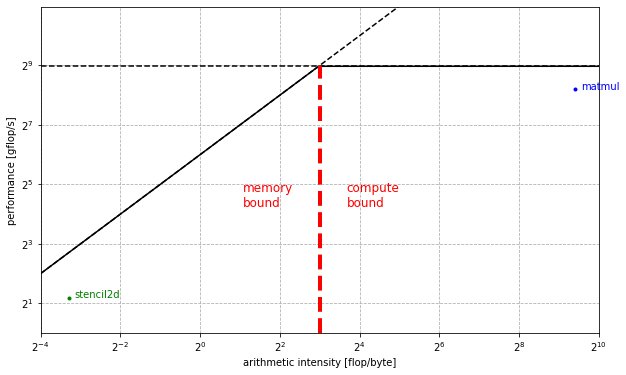

In [20]:
operational_intensity = 2 ** np.linspace(-4, 10, 100)
roofline = np.minimum( operational_intensity * peak_bandwidth_in_gbs, peak_performance_in_gflops )
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
xlim = ( np.min(operational_intensity), np.max(operational_intensity) )
ylim = ( 0.25 * np.min(roofline), 4 * peak_performance_in_gflops )
ax.plot( operational_intensity, roofline, 'k-');
ax.plot( operational_intensity, np.repeat(peak_performance_in_gflops, 100), 'k', linestyle="dashed" );
ax.plot( operational_intensity, operational_intensity * peak_bandwidth_in_gbs, 'k', linestyle="dashed" );
ax.text( 2.1, 19, 'memory\nbound', color='red', fontsize=12)
ax.plot( [8,8], [ylim[0], peak_performance_in_gflops ], 'r', linewidth=4, linestyle="dashed")
plt.xlabel("arithmetic intensity [flop/byte]");
plt.ylabel("performance [gflop/s]");
plt.xlim( xlim )
plt.ylim( ylim );
plt.grid(True, which="both", ls='--');
ax.text( 12.8, 19, 'compute\nbound', color='red', fontsize=12)

# TODO: add point for matrix-matrxi multiplication
ax.plot( matmul_intensity, matmul_gflops, 'b.')
ax.text( 1.1*matmul_intensity, matmul_gflops, "matmul", color='blue')

# TODO: add point for stencil_2d.F90 at nx=128 ny=128 nz=64 num_iter=1024
ax.plot( stencil2d_intensity, stencil2d_gflops, 'g.')
ax.text( 1.1*stencil2d_intensity, stencil2d_gflops, "stencil2d", color='green')

plt.show()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>18.</b> Add a data point for the <tt>stencil2d-counter.F90</tt> program (see next Jupyter notebook and uncomment corresponding section in plot above). Is the stencil program compute bound or memory bound? What could you do to improve the performance of the program?<br>
</div>

In [6]:
# from stencil_2d.F90 with nx=128 ny=128 nz=64 num_iter=1024
stencil2d_gflop_counter = 25.904525756835938 # TODO
stencil2d_gb_counter = 255.2354736328125 # TODO
stencil2d_runtime = 11.4283 # TODO
stencil2d_intensity = stencil2d_gflop_counter / stencil2d_gb_counter # TODO
stencil2d_gflops = stencil2d_gflop_counter / stencil2d_runtime # TODO

<div class="alert alert-block alert-success">
<b>Now it's your turn...</b><br>
<b>19 (Bonus).</b> Add a data point for the matrix-matrix multiplication example below (uncomment corresponding section in plot above). What will happen if you decrease the matrix size $n$? Try it out!<br>
<b>20 (Bonus).</b> There are a lot of resources to be found about memory bandwidth, arithmetic intensity and the roofline model. Spend some time researching more background information, for example for example <a href="http://www.dam.brown.edu/people/lgrinb/APMA2821/Lectures_2015/APMA2821H-L_roof_line_model.pdf">here</a>.<br>
</div>

In [7]:
n = 8 * 1024
A = np.random.rand(n, n)
B = np.random.rand(n, n)

tic = timeit.default_timer()
C = A.dot(B)
toc = timeit.default_timer()
execution_time = toc - tic

# approximated for large n
matmul_flops = 2 * n**3 / execution_time # TODO
matmul_intensity = ( 2 * n**3 ) / ( 3 * n**2 * 8 ) # TODO
matmul_gflops = matmul_flops * 1.e-9 # TODO